In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# base_dir='/content/drive/MyDrive/ucd/'
base_dir='../../folders/'

In [2]:
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model,load_model
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, DepthwiseConv1D, BatchNormalization, ReLU, GlobalAveragePooling1D, Dense
from keras.layers import Conv1D, SeparableConv1D,GlobalAveragePooling1D,Add,concatenate, Conv2D,MaxPooling1D,MaxPooling2D, Dropout,Dense,Flatten,Activation, Flatten, BatchNormalization,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import scipy.stats as stats
from keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

C:\Users\zazaz\AppData\Local\Temp\ipykernel_2476\265848756.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# !pip install QKeras
from qkeras import *
import pprint
from qkeras.autoqkeras import *
from qkeras import *
from qkeras.qtools import run_qtools
from qkeras.qtools import settings as qtools_settings

In [4]:
from tensorflow.keras import backend as K

def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        y_true = K.cast(y_true, 'float32')
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        y_true = K.cast(y_true, 'float32')
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [5]:
with open(base_dir+f'all/train_all.pkl', 'rb') as f:
                res = pickle.load(f)
                x_train = res['x_train']
                y_train = res['y_train']
del res
x_train=np.reshape(x_train,(len(x_train),3840,1))
print(x_train.shape)
print(y_train.shape)

(49797, 3840, 1)
(49797, 4)


In [6]:
with open(base_dir+f'all/test_all.pkl', 'rb') as f:
                res = pickle.load(f)
                x_test = res['x_test']
                y_test = res['y_test']
del res
x_test=np.reshape(x_test,(len(x_test),3840,1))
print(x_test.shape)
print(y_test.shape)

(12450, 3840, 1)
(12450, 4)


In [7]:

def depthwise_separable_conv_block(inputs, pointwise_conv_filters, alpha=1, depth_multiplier=1, strides=1, block_id=1):
    """Depthwise separable conv block.
    """
    pointwise_conv_filters = int(pointwise_conv_filters * alpha)

    x = DepthwiseConv1D((3,), padding='same', depth_multiplier=depth_multiplier, strides=strides)(inputs)
    x = BatchNormalization(name='conv_dw_%d_bn' % block_id)(x)
    x = QActivation("quantized_relu(8,1)")(x)

    x = QConv1D(pointwise_conv_filters, (1,), padding='same', use_bias=False, strides=(1,),kernel_quantizer=quantized_bits(8, 1,alpha=1), bias_quantizer=quantized_bits(8, 1,alpha=1))(x)
    x = BatchNormalization(name='conv_pw_%d_bn' % block_id)(x)
    x = QActivation("quantized_relu(8,1)")(x)

    return x

def MobileNet1D(input_shape, alpha=1, depth_multiplier=1, classes=10):
    """Instantiates the MobileNet architecture.
    """
    inputs = Input(shape=input_shape)

    x = depthwise_separable_conv_block(inputs, 32, alpha, depth_multiplier, strides=2, block_id=1)
    x = depthwise_separable_conv_block(x, 64, alpha, depth_multiplier, strides=1, block_id=2)
    x = depthwise_separable_conv_block(x, 128, alpha, depth_multiplier, strides=2, block_id=3)
    x = depthwise_separable_conv_block(x, 128, alpha, depth_multiplier, strides=1, block_id=4)
    x = depthwise_separable_conv_block(x, 256, alpha, depth_multiplier, strides=2, block_id=5)
    x = depthwise_separable_conv_block(x, 256, alpha, depth_multiplier, strides=1, block_id=6)
    x = depthwise_separable_conv_block(x, 512, alpha, depth_multiplier, strides=2, block_id=7)

    # Add more depthwise separable blocks if needed

    x = GlobalAveragePooling1D()(x)
    x = QDense(256,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu',kernel_quantizer=quantized_bits(8, 1,alpha=1), bias_quantizer=quantized_bits(8, 1,alpha=1))(x)
    x = QDense(classes,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='softmax',kernel_quantizer=quantized_bits(8, 1,alpha=1), bias_quantizer=quantized_bits(8, 1,alpha=1))(x)

    model = Model(inputs, x)

    return model


input_shape = (3840,1)
alpha = 1.0
depth_multiplier = 1
classes = 4  # Number of output classes

model = MobileNet1D(input_shape, alpha, depth_multiplier, classes)
model.summary()






Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3840, 1)]         0         
                                                                 
 depthwise_conv1d (Depthwise  (None, 1920, 1)          4         
 Conv1D)                                                         
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 1920, 1)          4         
 ation)                                                          
                                                                 
 q_activation (QActivation)  (None, 1920, 1)           0         
                                                                 
 q_conv1d (QConv1D)          (None, 1920, 32)          32        
                                                                 
 conv_pw_1_bn (BatchNormaliz  (None, 1920, 32)         128   

In [8]:
checkpoint = ModelCheckpoint(base_dir+"models/mobilenet_fp8.keras")
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy',f1])
history=model.fit(x_train,y_train,batch_size=256,epochs=200,callbacks=[checkpoint], validation_split=0.10)

Epoch 1/200
176/176 [==============================] - 84s 454ms/step - loss: 2.7414 - accuracy: 0.5681 - f1: 0.4978 - val_loss: 1.8134 - val_accuracy: 0.1319 - val_f1: 0.0000e+00
Epoch 2/200
176/176 [==============================] - 79s 447ms/step - loss: 1.0350 - accuracy: 0.6434 - f1: 0.6098 - val_loss: 1.5887 - val_accuracy: 0.1319 - val_f1: 0.0000e+00
Epoch 3/200
176/176 [==============================] - 79s 446ms/step - loss: 0.8381 - accuracy: 0.6954 - f1: 0.6758 - val_loss: 1.7810 - val_accuracy: 0.1554 - val_f1: 0.0968
Epoch 4/200
176/176 [==============================] - 78s 445ms/step - loss: 0.7565 - accuracy: 0.7304 - f1: 0.7161 - val_loss: 2.5149 - val_accuracy: 0.1691 - val_f1: 0.1426
Epoch 5/200
176/176 [==============================] - 79s 447ms/step - loss: 0.6965 - accuracy: 0.7572 - f1: 0.7464 - val_loss: 3.1890 - val_accuracy: 0.2137 - val_f1: 0.2041
Epoch 6/200
176/176 [==============================] - 78s 445ms/step - loss: 0.6479 - accuracy: 0.7837 - f1: 0.

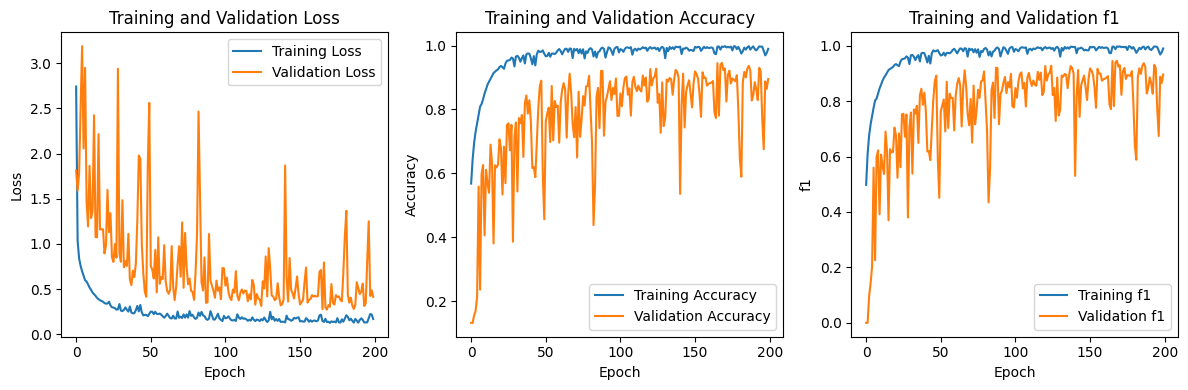

In [9]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


# Plot F1
plt.subplot(1, 3, 3)
plt.plot(history.history['f1'], label='Training f1')
plt.plot(history.history['val_f1'], label='Validation f1')
plt.title('Training and Validation f1')
plt.xlabel('Epoch')
plt.ylabel('f1')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
del x_train
del y_train

In [11]:
# model=load_model(base_dir+"models/mobilenet_fp8.keras",custom_objects={'f1':f1})
# model.summary()

In [12]:
y_pred=model.predict(x_test,batch_size=256)
y_pred = to_categorical(np.argmax(y_pred, axis=1), 4).astype(int)
y_pred=np.argmax(y_pred,axis=1)
y_test=np.argmax(y_test,axis=1)

49/49 [==============================] - 11s 215ms/step


In [13]:
print(classification_report(y_test,y_pred,target_names=['WAKE','REM','LIGHT','DEEP']))

              precision    recall  f1-score   support

        WAKE       0.95      0.76      0.85      2810
         REM       0.96      0.82      0.88      1809
       LIGHT       0.85      0.97      0.91      6233
        DEEP       0.88      0.86      0.87      1598

    accuracy                           0.89     12450
   macro avg       0.91      0.85      0.88     12450
weighted avg       0.89      0.89      0.89     12450



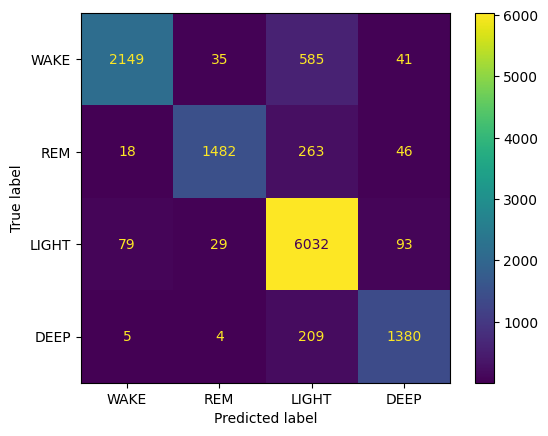

In [14]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['WAKE','REM','LIGHT','DEEP'])
disp.plot()
plt.show()

In [15]:
q = run_qtools.QTools(
    model,
    # energy calculation using a given process
    # "horowitz" refers to 45nm process published at
    # M. Horowitz, "1.1 Computing's energy problem (and what we can do about
    # it), "2014 IEEE International Solid-State Circuits Conference Digest of
    # Technical Papers (ISSCC), San Francisco, CA, 2014, pp. 10-14, 
    # doi: 10.1109/ISSCC.2014.6757323.
    
    process="horowitz",
    # quantizers for model input
    source_quantizers=["fp32"],
    
    is_inference=True,
    # whether model has been trained already, which is
    # needed to compute tighter bounds for QBatchNormalization Power estimation.
    
    # weights_path=None,
    # absolute path (including filename) of the model weights
    
    
    keras_quantizer="fp32",
    # keras_quantizer to quantize weight/bias in un-quantized keras layers
    
    keras_accumulator="fp32",
    # keras_quantizer to quantize MAC in un-quantized keras layers
    
    for_reference=False,
    # whether calculate baseline energy
)
q.qtools_stats_print()

# caculate energy of the derived data type map.
energy_dict = q.pe(
    # whether to store parameters in dram, sram, or fixed
    weights_on_memory="sram",
    # store activations in dram or sram
    activations_on_memory="sram",
    # minimum sram size in number of bits
    min_sram_size=8*16*1024*1024,
    # whether load data from dram to sram (consider sram as a cache
    # for dram. If false, we will assume data will be already in SRAM
    rd_wr_on_io=False)

# get stats of energy distribution in each layer
energy_profile = q.extract_energy_profile(qtools_settings.cfg.include_energy, energy_dict)
# extract sum of energy of each layer according to the rule specified in
# qtools_settings.cfg.include_energy
total_energy = q.extract_energy_sum(qtools_settings.cfg.include_energy, energy_dict)

pprint.pprint(energy_profile)
print()

print("Total energy: {:.2f} uJ".format(total_energy / 1000000.0))

Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.
CRITICAL:absl:unsupported kernel shape, it is neither a dense kernel of length 2, nor a convolution kernel of length 4
CRITICAL:absl:unsupported kernel shape, it is neither a dense kernel of length 2, nor a convolution kernel of length 4
CRITICAL:absl:unsupported kernel shape, it is neither a dense kernel of length 2, nor a convolution kernel of length 4
CRITICAL:absl:unsupported kernel shape, it is neither a dense kernel of length 2, nor a convolution kernel of length 4
CRITICAL:absl:unsupported kernel shape, it is neither a dense kernel of length 2, nor a convolution kernel of length 4
CRITICAL:absl:unsupported kernel shape, it is neither a dense kernel of length 2, nor a convolution kernel of length 4
CRITICAL:absl:unsupported kernel shape, it is neither a dense kernel of length 2, nor a convolution kernel of length 4


operation count for <keras.layers.convolutional.depthwise_conv1d.DepthwiseConv1D object at 0x0000018C5E0860A0> is defaulted to 0
operation count for <keras.layers.convolutional.depthwise_conv1d.DepthwiseConv1D object at 0x0000018C5E08A760> is defaulted to 0
operation count for <keras.layers.convolutional.depthwise_conv1d.DepthwiseConv1D object at 0x0000018C6D035F70> is defaulted to 0
operation count for <keras.layers.convolutional.depthwise_conv1d.DepthwiseConv1D object at 0x0000018C6D0E9FA0> is defaulted to 0
operation count for <keras.layers.convolutional.depthwise_conv1d.DepthwiseConv1D object at 0x0000018C6D0E6CD0> is defaulted to 0
operation count for <keras.layers.convolutional.depthwise_conv1d.DepthwiseConv1D object at 0x0000018C6D0A7FA0> is defaulted to 0
operation count for <keras.layers.convolutional.depthwise_conv1d.DepthwiseConv1D object at 0x0000018C6D131A60> is defaulted to 0
operation count for <keras.layers.pooling.global_average_pooling1d.GlobalAveragePooling1D object 

In [16]:
q = run_qtools.QTools(
    model,
    # energy calculation using a given process
    # "horowitz" refers to 45nm process published at
    # M. Horowitz, "1.1 Computing's energy problem (and what we can do about
    # it), "2014 IEEE International Solid-State Circuits Conference Digest of
    # Technical Papers (ISSCC), San Francisco, CA, 2014, pp. 10-14, 
    # doi: 10.1109/ISSCC.2014.6757323.
    
    process="horowitz",
    # quantizers for model input
    source_quantizers=["fp32"],
    
    is_inference=True,
    # whether model has been trained already, which is
    # needed to compute tighter bounds for QBatchNormalization Power estimation.
    
    # weights_path=None,
    # absolute path (including filename) of the model weights
    
    
    keras_quantizer="fp32",
    # keras_quantizer to quantize weight/bias in un-quantized keras layers
    
    keras_accumulator="fp32",
    # keras_quantizer to quantize MAC in un-quantized keras layers
    
    for_reference=True,
    # whether calculate baseline energy
)
q.qtools_stats_print()

# caculate energy of the derived data type map.
energy_dict = q.pe(
    # whether to store parameters in dram, sram, or fixed
    weights_on_memory="sram",
    # store activations in dram or sram
    activations_on_memory="sram",
    # minimum sram size in number of bits
    min_sram_size=8*16*1024*1024,
    # whether load data from dram to sram (consider sram as a cache
    # for dram. If false, we will assume data will be already in SRAM
    rd_wr_on_io=False)

# get stats of energy distribution in each layer
energy_profile = q.extract_energy_profile(qtools_settings.cfg.include_energy, energy_dict)
# extract sum of energy of each layer according to the rule specified in
# qtools_settings.cfg.include_energy
total_energy = q.extract_energy_sum(qtools_settings.cfg.include_energy, energy_dict)

pprint.pprint(energy_profile)
print()

print("Total energy: {:.2f} uJ".format(total_energy / 1000000.0))

operation count for <keras.layers.convolutional.depthwise_conv1d.DepthwiseConv1D object at 0x0000018C5E0860A0> is defaulted to 0
operation count for <keras.layers.convolutional.depthwise_conv1d.DepthwiseConv1D object at 0x0000018C5E08A760> is defaulted to 0
operation count for <keras.layers.convolutional.depthwise_conv1d.DepthwiseConv1D object at 0x0000018C6D035F70> is defaulted to 0
operation count for <keras.layers.convolutional.depthwise_conv1d.DepthwiseConv1D object at 0x0000018C6D0E9FA0> is defaulted to 0
operation count for <keras.layers.convolutional.depthwise_conv1d.DepthwiseConv1D object at 0x0000018C6D0E6CD0> is defaulted to 0
operation count for <keras.layers.convolutional.depthwise_conv1d.DepthwiseConv1D object at 0x0000018C6D0A7FA0> is defaulted to 0
operation count for <keras.layers.convolutional.depthwise_conv1d.DepthwiseConv1D object at 0x0000018C6D131A60> is defaulted to 0
operation count for <keras.layers.pooling.global_average_pooling1d.GlobalAveragePooling1D object 